In [2]:
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing, callbacks, Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Config
DATA_PATH = '/content/drive/MyDrive/CS4243'
TEST_DATA_PATH = DATA_PATH + '/test'
TRAIN_DATA_PATH = DATA_PATH + '/train'
PREPROCESSED_DATA_PATH = DATA_PATH + '/preprocessed'
PREPROCESSED_TRAIN_DATA_PATH = PREPROCESSED_DATA_PATH + '/train'
PREPROCESSED_TEST_DATA_PATH = PREPROCESSED_DATA_PATH + '/test'
SAMPLE_DATA = '/zzqtgk-0.png'

IMAGE_SHAPE = (400, 80) # (width, height)
IMG_WIDTH, IMG_HEIGHT = IMAGE_SHAPE

BATCH_SIZE = 32
CHARACTERS = '0123456789abcdefghijklmnopqrstuvwxyz'
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
MAX_LENGTH = 8 # determined from data labels

In [5]:
# Mapping Chars to Nums
char_to_num = layers.StringLookup(vocabulary=list(CHARACTERS), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

print(f"Vocab: {char_to_num.get_vocabulary()}")

Vocab: ['[UNK]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# Custom train test split since data is already divided
def get_train_test():
    X_train, X_test, y_train, y_test = [], [], [], []
    for img in os.listdir(TRAIN_DATA_PATH):
        X_train.append(os.path.join(TRAIN_DATA_PATH, img))
        y_train.append(img[:-6].lower())

    for img in os.listdir(TEST_DATA_PATH):
        X_test.append(os.path.join(TEST_DATA_PATH, img))
        y_test.append(img[:-6].lower())

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test()
print(X_train[:5])
print(y_train[:5])

['/content/drive/MyDrive/CS4243/train/zkw9nwd8-0.png', '/content/drive/MyDrive/CS4243/train/9a2xdo-0.png', '/content/drive/MyDrive/CS4243/train/2x44-0.png', '/content/drive/MyDrive/CS4243/train/z4pbo-0.png', '/content/drive/MyDrive/CS4243/train/e0jnk-0.png']
['zkw9nwd8', '9a2xdo', '2x44', 'z4pbo', 'e0jnk']


In [7]:
# Training & Testing Dataset
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [8]:
def preprocess(image_path, label):
    # Load image from image path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image/255.
    image = tf.cast(image, tf.float32)

    # Convert label to numerical label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.pad(label, [[0, MAX_LENGTH - tf.shape(label)[0]]], constant_values=0)

    return {"ImageInput":image, "LabelInput":label}

# Apply the preprocessing function
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

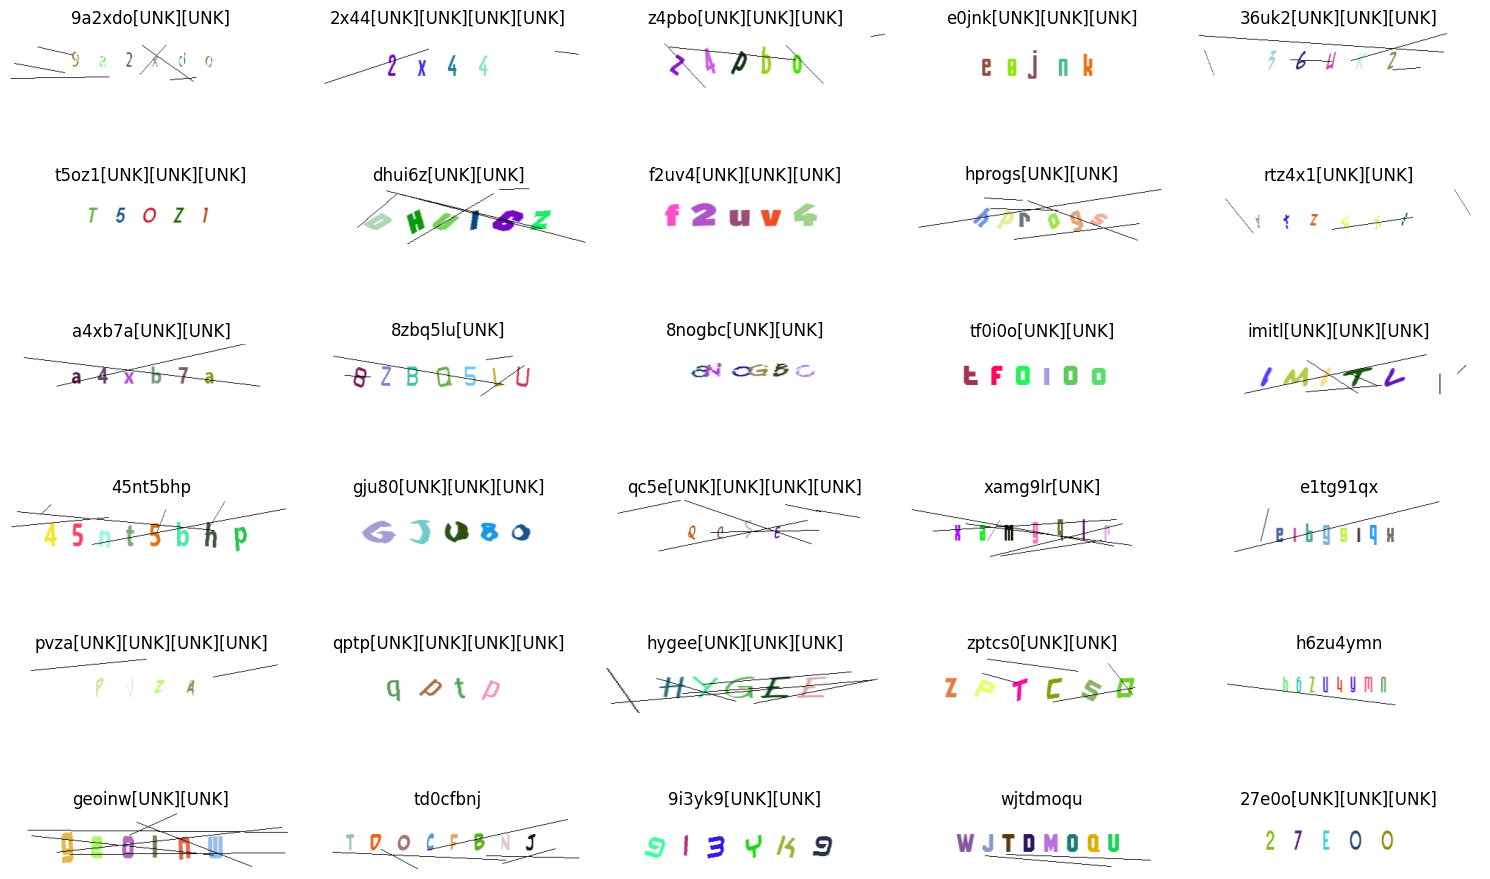

In [9]:
# Loop over images
plt.figure(figsize=(15, 10))

# Select a set of images
data = next(iter(train_ds.batch(BATCH_SIZE)))
images, labels = data['ImageInput'], data['LabelInput']

# Loop over the subset
for index in range(1, 31):

    # Extract info
    image = images[index]
    text_label = tf.strings.reduce_join(num_to_char(labels[index])).numpy().decode("utf-8")

    # Plot the subplot
    plt.subplot(6, 5, index)
    plt.imshow(image)
    plt.title(text_label)
    plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()

In [10]:
# Final process
train_ds = train_ds.repeat(5).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ctc_batch_loss = K.ctc_batch_cost

    def call(self, true, pred):

        batch_size = tf.cast(
            tf.shape(true)[0],
            dtype='int64'
        )

        input_length = tf.cast(
            tf.shape(pred)[1],
            dtype='int64'
        )

        output_length = tf.cast(
            tf.shape(true)[1],
            dtype='int64'
        )

        input_length *= tf.ones(shape=(batch_size, 1), dtype='int64')
        output_length *= tf.ones(shape=(batch_size, 1), dtype='int64')

        loss = self.ctc_batch_loss(true, pred, input_length, output_length)
        self.add_loss(loss)

        return pred

In [12]:
# CNN Encoder
encoder = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32'),
    layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer1"
    ),
    layers.MaxPool2D(name="MaxPoolLayer1"),
    layers.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="ConvLayer2"
    ),
    layers.MaxPool2D(name="MaxPoolLayer2"),
    layers.Reshape(target_shape=(IMG_WIDTH//4, (IMG_HEIGHT//4)*64), name="ReshapeEmbedding"),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', name="ImageEmbeding")

], name="CNN-Encoder")

In [13]:
# LSTM Decoder
decoder = Sequential([
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer1"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25), name="LSTMLayer2"),
], name="LSTM-Decoder")

In [14]:
# Input layers for the Image and Label input
image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32', name="ImageInput")
label_input = layers.Input(shape=(None, ), dtype='float32', name="LabelInput")

# Encoder & decoder network
embeddings = encoder(image_input)
dropout = layers.Dropout(0.5, name="EmbeddingDropout")(embeddings)
output_seq = decoder(dropout)
output_seq = layers.Dense(units=len(char_to_num.get_vocabulary()) + 1, activation='softmax', name="OutputSequence")(output_seq)

# CTC Loss Layer
ctc_loss = CTCLayer(name="CTCLoss")(label_input, output_seq)

# CTC Model
ctc_model = models.Model(
    inputs=[image_input, label_input],
    outputs=[ctc_loss],
    name="CTCModel"
)

# Model Architecture Summary
ctc_model.summary()

Model: "CTCModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ImageInput (InputLayer)     [(None, 80, 400, 3)]         0         []                            
                                                                                                  
 CNN-Encoder (Sequential)    (None, 100, 64)              101376    ['ImageInput[0][0]']          
                                                                                                  
 EmbeddingDropout (Dropout)  (None, 100, 64)              0         ['CNN-Encoder[0][0]']         
                                                                                                  
 LSTM-Decoder (Sequential)   (None, 100, 64)              49664     ['EmbeddingDropout[0][0]']    
                                                                                           

In [15]:
# Model Visualization
keras.utils.plot_model(
    ctc_model,
    to_file="CTCModel.png",
    show_shapes=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
# Model Compilation
ctc_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)
# checkpoint_model = keras.callbacks.ModelCheckpoint(
#     filepath=DATA_PATH + '/model.keras',
#     save_best_only=True,
#     verbose=1
# )

# Model training
history = ctc_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=100,
    callbacks=[
        early_stopping,
        lr_scheduler
    ]
)

Epoch 1/100
1250/1250 [==============================] - 500s 270ms/step - loss: 27.6452 - val_loss: 25.1832 - lr: 0.0010
Epoch 2/100
1250/1250 [==============================] - 329s 263ms/step - loss: 25.0101 - val_loss: 24.6604 - lr: 0.0010
Epoch 3/100
1250/1250 [==============================] - 329s 263ms/step - loss: 24.4897 - val_loss: 24.3871 - lr: 0.0010
Epoch 4/100
1250/1250 [==============================] - 329s 263ms/step - loss: 24.1638 - val_loss: 24.2117 - lr: 0.0010
Epoch 5/100
1250/1250 [==============================] - 330s 264ms/step - loss: 23.9043 - val_loss: 24.0622 - lr: 0.0010
Epoch 6/100
1250/1250 [==============================] - 331s 265ms/step - loss: 23.6713 - val_loss: 23.9166 - lr: 0.0010
Epoch 7/100
1250/1250 [==============================] - 332s 266ms/step - loss: 23.5003 - val_loss: 24.2365 - lr: 0.0010
Epoch 8/100
1250/1250 [==============================] - 330s 264ms/step - loss: 23.3162 - val_loss: 23.4725 - lr: 0.0010
Epoch 9/100
1250/1250 [=

In [17]:
## save model
ctc_model.save(DATA_PATH + '/model_mnist.keras')

In [18]:
# Convert to a DataFrame
history_df = pd.DataFrame(history.history)

# Visualize the History
import plotly.express as px
fig = px.line(history_df, y=["loss", "val_loss"], title="Learning Curve")
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Sparse Categorical Crossentropy",
)
fig.show()

In [19]:
testing_loss = ctc_model.evaluate(test_ds,  verbose=0)
print(f"Model Testing Loss: {testing_loss}")

Model Testing Loss: 23.30644416809082


In [20]:
# Define input and output tensors
image_input_tensor = ctc_model.inputs[0]
output_sequence_tensor = ctc_model.get_layer("OutputSequence").output

# Create the prediction model using input and output tensors
ocr_pred_model = keras.Model(inputs=image_input_tensor, outputs=output_sequence_tensor)
ocr_pred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 80, 400, 3)]      0         
                                                                 
 CNN-Encoder (Sequential)    (None, 100, 64)           101376    
                                                                 
 EmbeddingDropout (Dropout)  (None, 100, 64)           0         
                                                                 
 LSTM-Decoder (Sequential)   (None, 100, 64)           49664     
                                                                 
 OutputSequence (Dense)      (None, 100, 38)           2470      
                                                                 
Total params: 153510 (599.65 KB)
Trainable params: 153510 (599.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
def decode_prediction(model_pred_seq):

    # Compute the Input length
    input_length = np.ones(model_pred_seq.shape[0]) * model_pred_seq.shape[1]

    # Decode the model predictions (& select the required stuff)
    decode = tf.squeeze(keras.backend.ctc_decode(model_pred_seq, input_length=input_length, greedy=True)[0])

    # Conver the numbers to their respective characters
    decoded_text = [tf.strings.reduce_join(num_to_char(nums)) for nums in decode]

    # Convert thode characters back to a normal string
    decoded_text = [text.numpy().decode().replace('[UNK]', '') for text in decoded_text]

    return decoded_text

['zj', 'zi', 'z', 'zv', 'z', 'zj', 'me', 'zy', 'f', 'z', 'zi', 'zv', 'c', 'zj', 'zy', 'me', 'zi', 'zj', '67', 'ff', 'zv', '6', '67', 'm', 'ft', 'zy', 'zq', 'm', 'f', 'f', 'zi', '6t']


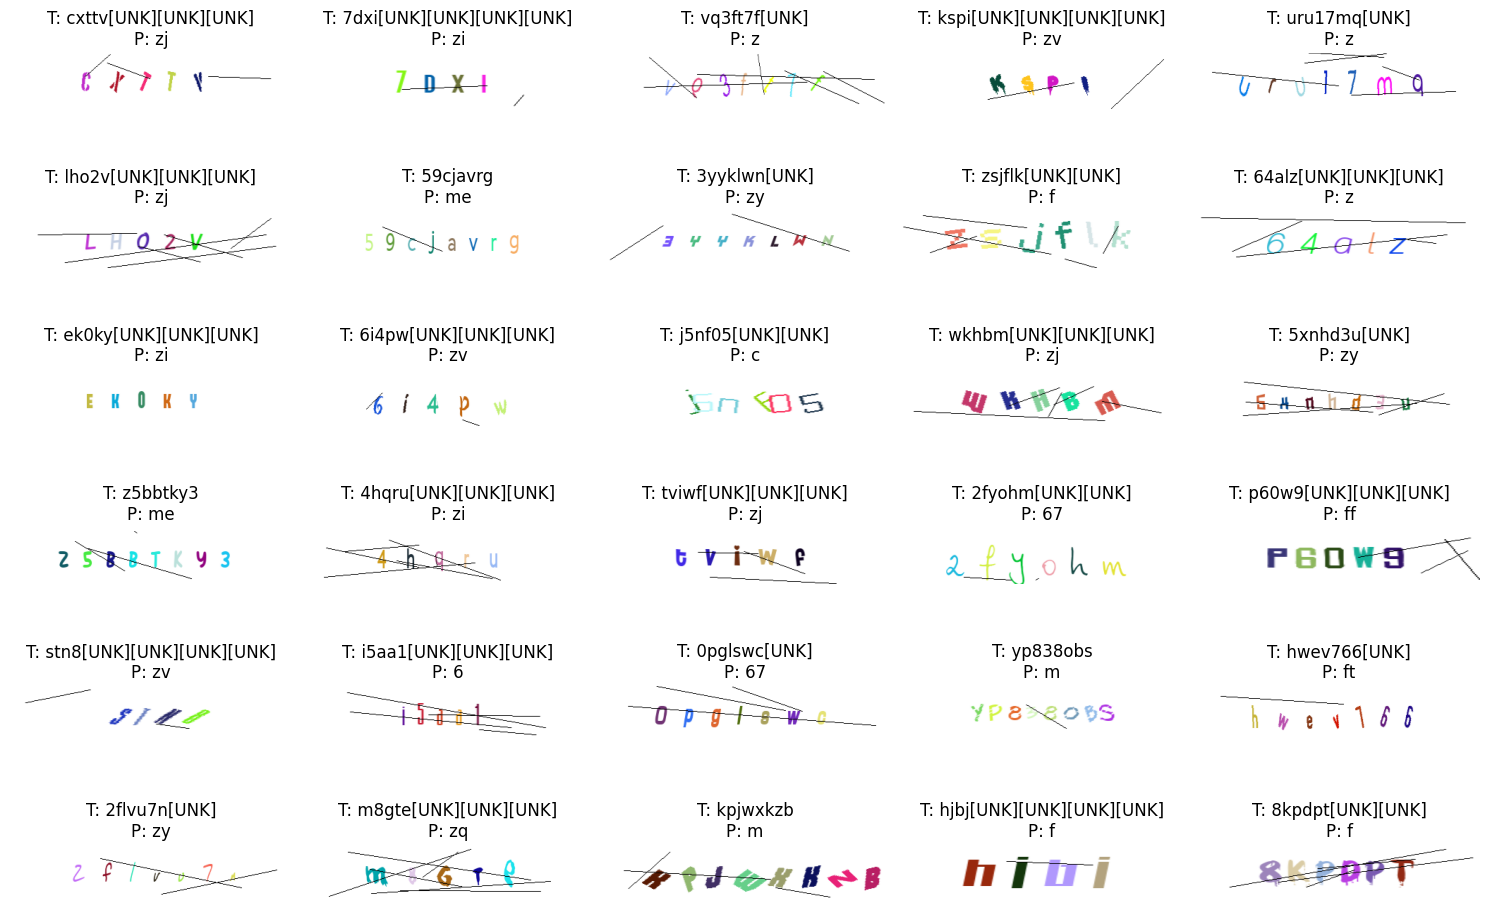

In [22]:
# Initialize Figure Size
plt.figure(figsize=(15, 10))

# Loop over a subset of images in the dataset
for data in test_ds.take(1):

    # Loop over individual images and labels
    images = data['ImageInput']
    labels = data['LabelInput']
    model_preds = decode_prediction(ocr_pred_model.predict(images, verbose=0))
    print(model_preds)

    for index in range(min(30, len(images))):

        # Extract info for each image and label
        image = images[index]
        true_label = labels[index]
        pred_label = model_preds[index]

        # Decode labels from numerical to text
        true_text = tf.strings.reduce_join(num_to_char(true_label)).numpy().decode("utf-8")

        # Plot the subplot
        plt.subplot(6, 5, index + 1)
        plt.imshow(image)  # Assuming images are grayscale
        plt.title(f'T: {true_text}\nP: {pred_label}')
        plt.axis('off')

# Plot Configs
plt.tight_layout()
plt.show()


In [23]:
## Custom captcha accuracy
y_pred_full = ctc_model.predict(test_ds, verbose=0)
y_pred_full = decode_prediction(y_pred_full)

y_true_full = []
for data in test_ds:
    # Append the 'LabelInput' to y_true_full list
    y_true_full.extend(data['LabelInput'].numpy())

# Convert the list of tensors into a single NumPy array
y_true_full = np.array(y_true_full)
y_true_full = [tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8") for label in y_true_full]

def captcha_accuracy(y_true, y_pred):
    total_chars = 0
    correct_chars = 0
    total_words = len(y_true)
    correct_words = 0

    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_chars += len(true_label)
            correct_words += 1
        else:
            correct_chars += len(set(true_label) & set(pred_label))
        total_chars += len(true_label)

    print(f"Correct: {correct_chars}")
    print(f"Total: {total_chars}")
    print(f"Correct: {correct_words}")
    print(f"Total: {total_words}")
    return correct_chars / total_chars, correct_words / total_words

char_accuracy, word_accuracy = captcha_accuracy(y_true_full, y_pred_full)
print(f"Character Accuracy: {char_accuracy}")
print(f"Word Accuracy: {word_accuracy}")

Correct: 524
Total: 31712
Correct: 0
Total: 1984
Character Accuracy: 0.016523713420787085
Word Accuracy: 0.0
